In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

## Getting the data and preprocess it

In [2]:
train_df = pd.read_csv('../Data/Processed/train.csv')
val_df = pd.read_csv('../Data/Processed/val.csv')
test_df = pd.read_csv('../Data/Processed/test.csv')


train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()


In [3]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))

In [4]:
output_seq_len

55

In [5]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

E:\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [6]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Create word embedding

In [7]:
# Number of words in our vocabulary
max_tokens = 68000

In [8]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # Number of words in vocabulary
                                   output_sequence_length = 55) # desired output length of vectorized sequences


In [9]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [10]:
# Create one-hot-encoded tensors 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                       depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                     depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                      depth = 15)

In [11]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [12]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

## Create char embedding

In [13]:
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
output_seq_char_len = int(np.percentile(char_lens, 95))

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
# Create char-level token vectorizer instance

# num characters in alphabet + space + OOV (out of vocabulary or unknown)
NUM_CHAR_TOKENS = len(alphabet) + 2 
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                   output_sequence_length = output_seq_char_len,
                                   standardize = "lower_and_strip_punctuation",
                                   name = "char_vectorizer") 

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character 
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

## Create dataset

In [14]:
# Create one-hot-encoded tensors 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                       depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                     depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                      depth = 15)

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Create model

In [21]:
# Step 1. Token inputs

token_inputs = layers.Input(shape = [], dtype = "string",
                           name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs = token_outputs)


# Step 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = "string",
                          name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(units = 24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                           outputs = char_bi_lstm)


# Step 3. Line numbers inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32,
                                 name = 'line_number_inputs')
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                  outputs = x)


# Step 4. Total lines inputs
total_line_inputs = layers.Input(shape = (20,), dtype = tf.int32,
                                name = "total_lines_inputs")
y = layers.Dense(32, activation = "relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01))(total_line_inputs)
y = layers.Dense(24, activation = "relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
total_line_model = tf.keras.Model(inputs = total_line_inputs,
                                 outputs = y)


# Step 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output,
                                                                               char_model.output])

z = layers.Dense(82, activation = "relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined_embeddings)
z = layers.Dropout(0.5)(z)
z = layers.Dense(32, activation = "relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01))(z)
z = layers.Dropout(0.5)(z)


# Step 6. Combine positional embeddings with combined token and char embedding
z = layers.Concatenate(name = "token_char_positional_embedding")([line_number_model.output,
                                                                 total_line_model.output,
                                                                 z])

# Step 7. Create output layer
output_layer = layers.Dense(5, activation = "softmax",
                           name = "output_layer")(z)

# Step 8. Put all together
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                  total_line_model.input,
                                  token_model.input,
                                  char_model.input],
                        outputs = output_layer)

In [22]:
# Compile the model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

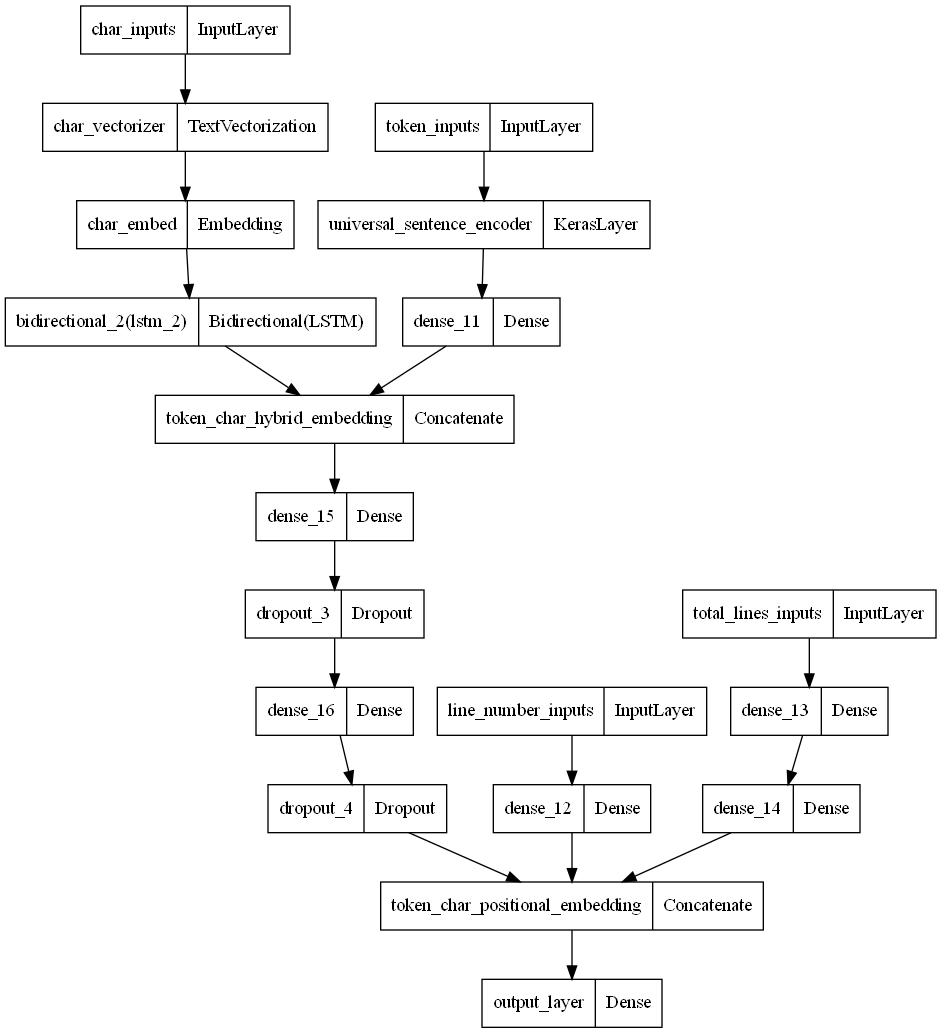

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [19]:
model_5.save('model_5_saved_file')


INFO:tensorflow:Assets written to: model_5_saved_file\assets


INFO:tensorflow:Assets written to: model_5_saved_file\assets
